In [19]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from scipy.optimize import curve_fit

In [20]:
dat_files_list = glob.glob(os.path.join('1-spot-estimation','*.dat'))
print(dat_files_list)

['1-spot-estimation\\20230809-133540__eduardo__THZ55-60__PMP0__S2207L__5RH__295.8K__Air__WithoutHole.dat', '1-spot-estimation\\20230809-133703__eduardo__THZ55-60__PMP0__S2207L__5RH__295.8K__Air__WithoutHole.dat', '1-spot-estimation\\20230809-133824__eduardo__THZ55-60__PMP0__S2207L__5RH__295.7K__Air__WithoutHole.dat', '1-spot-estimation\\20230809-134310__eduardo__THZ55-60__PMP0__S2207L__5RH__295.9K__Air__50-2mm.dat', '1-spot-estimation\\20230809-134430__eduardo__THZ55-60__PMP0__S2207L__5RH__295.9K__Air__50-2mm.dat', '1-spot-estimation\\20230809-134551__eduardo__THZ55-60__PMP0__S2207L__5RH__295.9K__Air__50-2mm.dat', '1-spot-estimation\\20230809-135252__eduardo__THZ55-60__PMP0__S2207L__5RH__295.9K__Air__45-2mm.dat', '1-spot-estimation\\20230809-135414__eduardo__THZ55-60__PMP0__S2207L__5RH__295.9K__Air__45-2mm.dat', '1-spot-estimation\\20230809-135536__eduardo__THZ55-60__PMP0__S2207L__5RH__295.9K__Air__45-2mm.dat', '1-spot-estimation\\20230809-140510__eduardo__THZ55-60__PMP0__S2207L__5RH__

In [21]:
dict_of_all_dfs = {}
for file_name in dat_files_list:
    df = pd.read_csv(file_name, sep="	")
    file_name_sep = file_name.split('__')
    df_name = file_name_sep[0].split('\\')[1] + '_' + file_name_sep[-1][0:-4]
    dict_of_all_dfs[df_name] = df

# Constants

In [22]:
c = 3e8 # meter per second
N = dict_of_all_dfs['20230809-133540_WithoutHole']['X'].shape[0]
print(f"c = {c:.1e} m/s \nN = {N}")

c = 3.0e+08 m/s 
N = 1001


# Transforming the position column

The position column `pos` are positions from the delay line. Since the light speed is constant, we can transform the data to moment in time and set to a relative moment. I'll set $t=0$ the moment whose X is maximum for the data **without hole**. The times are calculated as:

$$
t_n = 2(x_n - x_0) / c,
$$

Where $x_n$ is the n-th position of the delay line and c is the speed of light. The factor 2 is because the displacement of the delay line doubles the beam path.

In [23]:
id_max_X = dict_of_all_dfs['20230809-133540_WithoutHole']['X'].idxmax()
for df in dict_of_all_dfs.values():
    df['time_moment'] = (df['pos']-df['pos'][id_max_X])*2e-3/c

In [24]:
time_step = dict_of_all_dfs['20230809-133540_WithoutHole']['time_moment'][1] - dict_of_all_dfs['20230809-133540_WithoutHole']['time_moment'][0]
print(f"\ntime step = {time_step*1e12:1.3f} ps")


time step = 0.033 ps


# Plot of all pulses

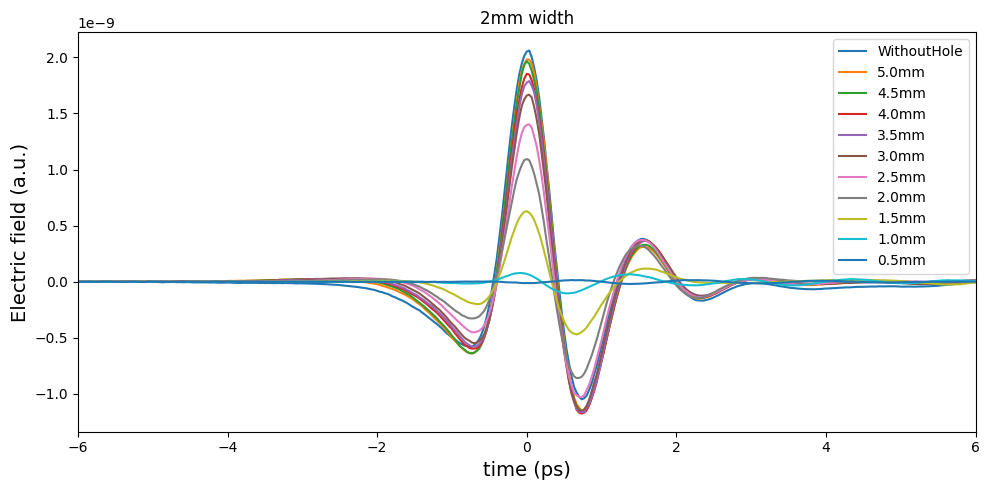

In [25]:
id = 0
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)
leg=[]
for df_name, df in dict_of_all_dfs.items():
    id = id+1
    if id%3>0:
        continue
    if (df_name[-11:] == 'WithoutHole') or (int(df_name[-3])==2):
        ax.plot(df['time_moment']*1e12, df['X'])
        ax.set_xlabel('time (ps)', fontsize=14)
        ax.set_ylabel('Electric field (a.u.)',fontsize=14)
        ax.set_xlim((-6,6))
        leg.append(df_name[-6]+'.'+df_name[-5] + 'mm')
leg[0] = 'WithoutHole'
ax.set_title('2mm width')
ax.legend(leg)
plt.show()

In [26]:
dict_of_all_dfs_fft = {key_name+"_fft": np.conj(fft(df['X'])) for key_name, df in dict_of_all_dfs.items()}

# Plot of intensity ($I \propto |E(t)|^2$)

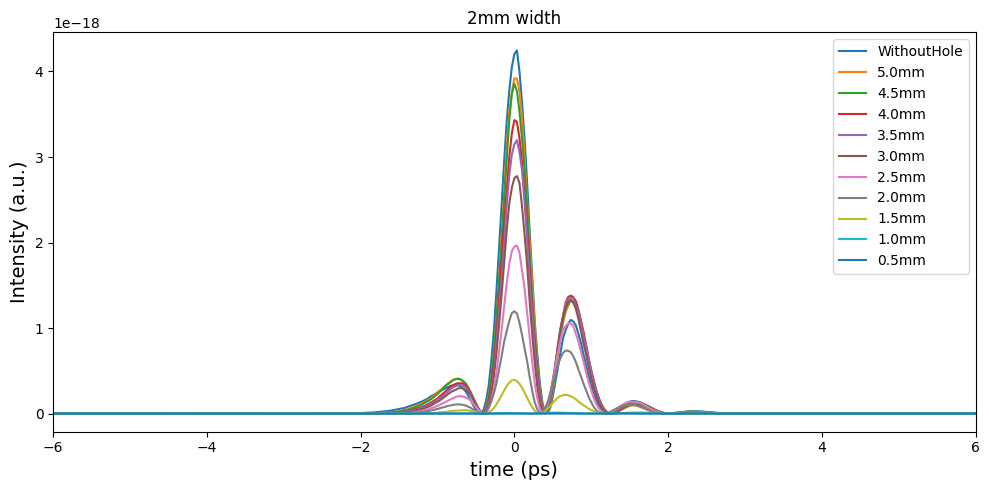

In [27]:
id = 0
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)
leg=[]
for df_name, df in dict_of_all_dfs.items():
    id = id+1
    if id%3>0:
        continue
    if (df_name[-11:] == 'WithoutHole') or (int(df_name[-3])==2):
        ax.plot(df['time_moment']*1e12, df['X']*df['X'])
        ax.set_xlabel('time (ps)', fontsize=14)
        ax.set_ylabel('Intensity (a.u.)',fontsize=14)
        ax.set_xlim((-6,6))
        leg.append(df_name[-6]+'.'+df_name[-5] + 'mm')
leg[0] = 'WithoutHole'
ax.set_title('2mm width')
ax.legend(leg)
plt.show()

# Pulse waist

The pulse emitted by the laser, and the terahertz pulse generated, is gaussian. This means that the **spatial** distribution of the intensity over the plane perpendicular to the propagation direction is gaussian:

$$
I(r) = I_0  e^{-2r^2/w_0^2}
$$

When we have a circular aperture the total power transmitted is an integral in polar coordinates:

$$
P(D) = \int_A I(r)\text{d}A = \int_0^{2\pi} \int_0^{D/2}I_0 e^{-r^2/2w_0^2}\text{d}\theta\text{d}r = \frac{\pi w_0^2 I_0}{2}(1-e^{-D^2/2w_0^2}),
$$
where the total power $P_0$ without hole is given by:

$$
P_0 = \frac{\pi w_0^2 I_0}{2}.
$$

So, the expression for the power in function of the aperture diameter is:

$$
P(D) = P_0(1 - e^{-D^2/2w_0^2}).
$$

The aperture only reduces the amplitude of the electric field, and the field temporal shape remains unchanged. With this assumptions is reasonable to say that the relative transmitted power is proportional to the intensity peak.

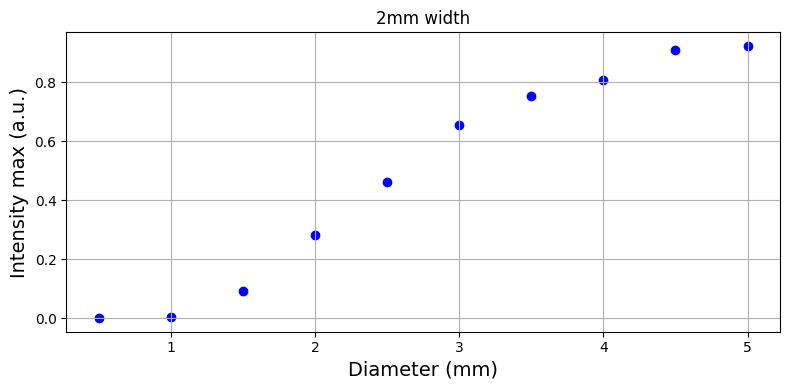

In [28]:
id = 0
peak_max_list = []
diameters = []
for df_name, df in dict_of_all_dfs.items():
    id = id+1
    if id%3>0:
        continue
    if (df_name[-11:] == 'WithoutHole'):
        intensity_norm = max(df['X']*df['X'])
        continue
    elif (int(df_name[-3])==2):
        peak_max = max(df['X']*df['X'])/intensity_norm
        peak_max_list.append(peak_max)
        D=float(df_name[-6]+'.'+df_name[-5])
        diameters.append(D)
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
ax.scatter(diameters, peak_max_list,c='blue')
ax.set_xlabel('Diameter (mm)',fontsize=14)
ax.set_ylabel('Intensity max (a.u.)',fontsize=14)
ax.set_title('2mm width')
# ax.set_ylim((-.05,1))
ax.grid()
plt.show()

# Fitting the model

We have 3 datasets for each aperture size, so for the fit I'm using mean value for the peak maximum. I'm using the module `curve_fit` from `scipy`, that applies a non-linear least mean square method to fit the model. 

In [29]:
id = 0
peak_max_list = []
diameters = []
peak_triple_list = []
for df_name, df in dict_of_all_dfs.items():
    if (df_name[-11:] == 'WithoutHole'):
        intensity_norm = max(df['X']*df['X'])
        continue
    elif (int(df_name[-3])==2):
        peak_max = max(df['X']*df['X'])/intensity_norm
        peak_triple_list.append(peak_max)
    id = id+1
    if id%3==0 and id<31:
        peak_max = np.mean(peak_triple_list)
        peak_max_list.append(peak_max)
        D=float(df_name[-6]+'.'+df_name[-5])
        diameters.append(D)
        peak_triple_list = []

In [30]:
def power_model(D, P0, w0):
    return P0*(1 - np.exp(-D**2/(2 * w0**2)))

In [31]:
params, covariance = curve_fit(power_model, diameters, peak_max_list)

## Covariance matrix

Our model consist of 2 parameters: $P_0$ and $w_0$. $P_0$ should be equal 1, since we're dealing with the intensities normalized by the intensity without hole. The fit gives us the following covariance matrix:

$$
\begin{pmatrix}
\sigma_{P_0}^2 & \sigma_{P_0,w_0} \\
\sigma_{w_0,P_0} & \sigma_{w_0}^2
\end{pmatrix}
$$

Where the standard deviation $\sigma_{w_0}$ of our desired parameter (the beam waist $w_0$) is $\sqrt{\sigma_{w_0}^2}$. Here I'm estimating the error as equal to $\sigma_{w_0}$.

In [32]:
print(f'P0 = {params[0]:1.2f}({np.sqrt(covariance[0][0])*100%100:1.0f})')
print(f'w0 = {params[1]:1.2f}({np.sqrt(covariance[1][1])*100%100:1.0f}) mm')
print(f'FWHM = {params[1]*np.sqrt(2*np.log(2)):1.2f} mm \n')
print(covariance)

P0 = 1.06(10)
w0 = 2.36(23) mm
FWHM = 2.78 mm 

[[0.0094901  0.02062133]
 [0.02062133 0.05106546]]


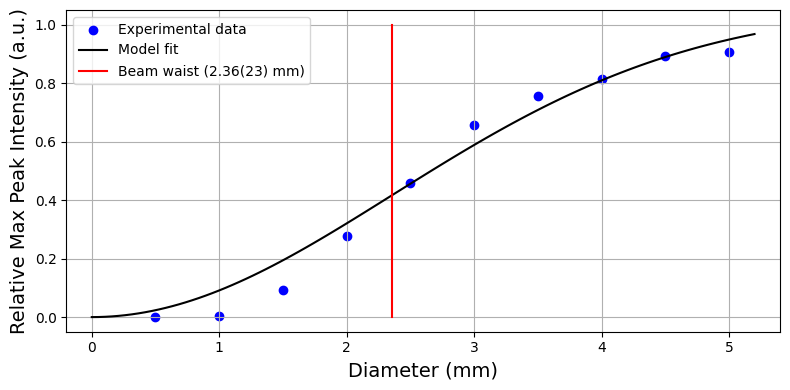

In [34]:
fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
ax.scatter(diameters, peak_max_list, c='blue')
ax.plot(np.linspace(0,5.2,100), power_model(np.linspace(0,5.2,100), *params),'k')
ax.set_xlabel("Diameter (mm)", fontsize=14)
ax.set_ylabel("Relative Max Peak Intensity (a.u.)", fontsize=14)
ax.set_xlim((-.2,5.4))
ax.plot([params[1], params[1]], [0, 1.0],'r')
ax.legend(["Experimental data", "Model fit", "Beam waist (2.36(23) mm)"])
ax.grid()
plt.show()